In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Downloading the Data and getiing it situated in pandas data frames

In [2]:
# Download data for XOM, CVX, and SHEL
data_xom = yf.download('XOM', start='2005-01-01', end='2020-01-01')  # ExxonMobil Data
data_cvx = yf.download('CVX', start='2005-01-01', end='2020-01-01')  # Chevron Data
data_shel = yf.download('SHEL', start='2005-01-01', end='2020-01-01')  # Shell Data

# Creating a usable data frame for later data manipulation
data = pd.concat([data_xom['Close'], data_cvx['Close'], data_shel['Close']], axis=1)
data.columns = ['XOM-CLOSE', 'CVX-CLOSE', 'SHEL-CLOSE']

# Look at head to make sure the data is in the correct format
data.head()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,XOM-CLOSE,CVX-CLOSE,SHEL-CLOSE
Date,,,
2005-01-03,25.789066,23.952736,20.577061
2005-01-04,25.614006,23.788025,20.318302
2005-01-05,25.480150,23.943327,20.321949
2005-01-06,25.804499,24.343304,20.383900
2005-01-07,25.634604,24.070374,20.307367


In [3]:
# Calculate the correlation for the individual stocks to be used later
# Doing a 90-day rolling window to see the data in that time frame
correlation_xom_cvx_90 = data['XOM-CLOSE'].rolling(window=90).corr(data['CVX-CLOSE'])
correlation_xom_shel_90 = data['XOM-CLOSE'].rolling(window=90).corr(data['SHEL-CLOSE'])
correlation_cvx_shel_90 = data['CVX-CLOSE'].rolling(window=90).corr(data['SHEL-CLOSE'])

#Also did a 50-day rolling window to see movement on a smaller scale as well
correlation_xom_cvx_50 = data['XOM-CLOSE'].rolling(window=50).corr(data['CVX-CLOSE'])
correlation_xom_shel_50 = data['XOM-CLOSE'].rolling(window=50).corr(data['SHEL-CLOSE'])
correlation_cvx_shel_50 = data['CVX-CLOSE'].rolling(window=50).corr(data['SHEL-CLOSE'])

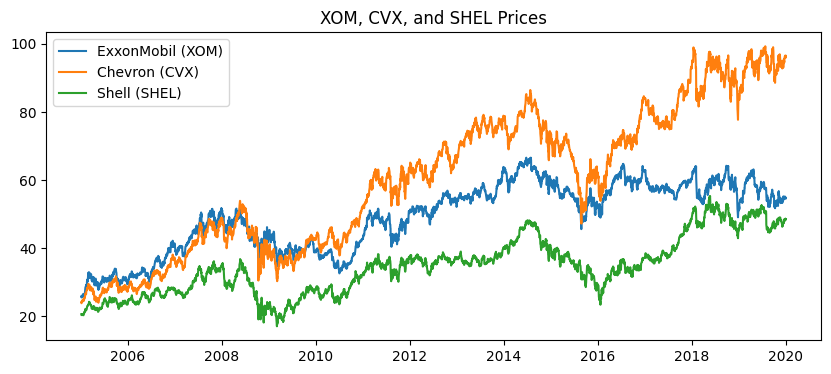

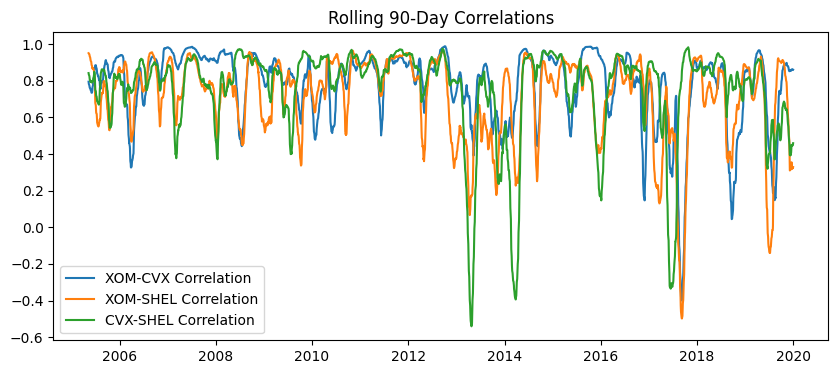

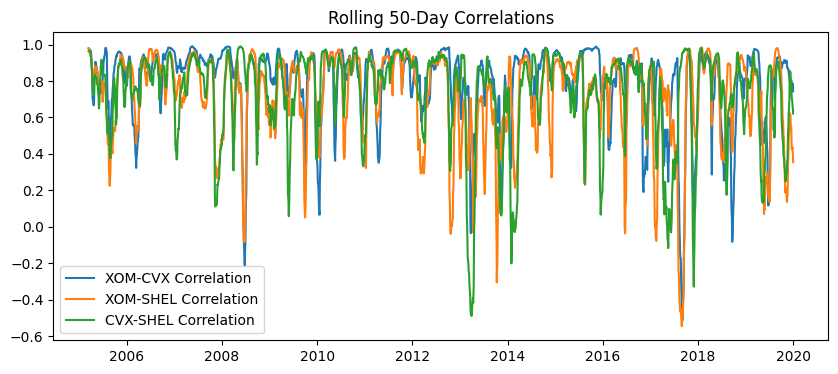

In [4]:
# Plot all three stock prices using plt.plot
plt.figure(figsize=(10, 4))
plt.plot(data['XOM-CLOSE'], label='ExxonMobil (XOM)')
plt.plot(data['CVX-CLOSE'], label='Chevron (CVX)')
plt.plot(data['SHEL-CLOSE'], label='Shell (SHEL)')
plt.title('XOM, CVX, and SHEL Prices')
plt.legend()
plt.show()

# Plot all three correlations by plotting their correlations with one another in a 90-day rolling period
# Having their distinctive graphs to see each one
plt.figure(figsize=(10, 4))
plt.plot(correlation_xom_cvx_90, label='XOM-CVX Correlation')
plt.plot(correlation_xom_shel_90, label='XOM-SHEL Correlation')
plt.plot(correlation_cvx_shel_90, label='CVX-SHEL Correlation')
plt.title('Rolling 90-Day Correlations')
plt.legend()
plt.show()

# Plotting the 50-day rolling window
plt.figure(figsize=(10, 4))
plt.plot(correlation_xom_cvx_50, label='XOM-CVX Correlation')
plt.plot(correlation_xom_shel_50, label='XOM-SHEL Correlation')
plt.plot(correlation_cvx_shel_50, label='CVX-SHEL Correlation')
plt.title('Rolling 50-Day Correlations')
plt.legend()
plt.show()

In [5]:
# create variables with the max and min values amoung the data points
# take the highest and subtract the lowest to get the spread between the 3 data points
max = data[['XOM-CLOSE', 'CVX-CLOSE', 'SHEL-CLOSE']].max(axis=1)
min = data[['XOM-CLOSE', 'CVX-CLOSE', 'SHEL-CLOSE']].min(axis=1)
data['Spread'] = max - min

# calculate the mean of the spread of the data we have
mean_spread = data['Spread'].mean()

# calculate the standard deviation of the data we have
standard_deviation = data['Spread'].std()

# Calculate the rolling standard deviation over 180 days for for volitility calculations
data['rolling_std'] = data['Spread'].rolling(window=180).std()
data['rolling_std'] = data['rolling_std'].fillna(method='bfill')  # Backfill with next available value

<ipython-input-5-ba0e1eea1f52>:15: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['rolling_std'] = data['rolling_std'].fillna(method='bfill')  # Backfill with next available value


#Calulations and Volitility Based Approach



In [6]:
# Define thresholds for the volitility calculation
low_threshold = data['rolling_std'].quantile(0.33)
high_threshold = data['rolling_std'].quantile(0.75)


# Assign volatility regime according the certain inequalities
def classify_volatility(rolling_std, low, high):
    if rolling_std < low:
        return 'Low Volatility'
    elif rolling_std < high:
        return 'High Volatility'
    else:
        return 'Extreme Volatility'

# labeling each row with the volitility classification based on the rolling standard deviation
data['Volatility_Regime'] = data['rolling_std'].apply(lambda x: classify_volatility(x, low_threshold, high_threshold))
print(data['Volatility_Regime'].value_counts())

Volatility_Regime
High Volatility       1585
Low Volatility        1246
Extreme Volatility     944
Name: count, dtype: int64


In [7]:
# Calculate the Z-score that is going to be used as a trading signal
data['Z-Score'] = (data['Spread'] - mean_spread) / standard_deviation

# Calculate the Exponential Moving Average
ema_period = 90
data['EMA_Spread'] = data['Spread'].ewm(span=ema_period, adjust=False).mean()

# Paramters for the different boilinger bands
# low volitility EMA and smaller bands
low_vol_ema = 100
low_vol_k = 1.5

# high volitility and wider bands
high_vol_ema = 50
high_vol_k = 2

# extreme volitility and widest bands
extreme_vol_ema = 200
extreme_vol_k = 3.5

## Low volitility, recalculating the EMA and rolling_std for the smaller bands
# and creating the boilinger bands from the new EMA and rolling_std
data['EMA_LowVol'] = data['Spread'].ewm(span=low_vol_ema, adjust=False).mean()
data['Rolling_Std_LowVol'] = data['Spread'].rolling(window=low_vol_ema).std()
data['Rolling_Std_LowVol'] = data['Rolling_Std_LowVol'].fillna(method='bfill')
data['Lower_Band_LowVol'] = data['EMA_LowVol'] - low_vol_k * data['Rolling_Std_LowVol']
data['Upper_Band_LowVol'] = data['EMA_LowVol'] + low_vol_k * data['Rolling_Std_LowVol']

# high volitility, recalculating the EMA and rolling_std for the wider bands
# and creating the boilinger bands from the new EMA and rolling_std
data['EMA_HighVol'] = data['Spread'].ewm(span=high_vol_ema, adjust=False).mean()
data['Rolling_Std_HighVol'] = data['Spread'].rolling(window=high_vol_ema).std()
data['Rolling_Std_HighVol'] = data['Rolling_Std_HighVol'].fillna(method='bfill')
data['Lower_Band_HighVol'] = data['EMA_HighVol'] - high_vol_k * data['Rolling_Std_HighVol']
data['Upper_Band_HighVol'] = data['EMA_HighVol'] + high_vol_k * data['Rolling_Std_HighVol']

# Extreme volatility, recalculating the EMA and rolling_std for the widest bands
# and creating the Bollinger Bands from the new EMA and rolling_std
data['EMA_ExtremeVol'] = data['Spread'].ewm(span=extreme_vol_ema, adjust=False).mean()
data['Rolling_Std_ExtremeVol'] = data['Spread'].rolling(window=extreme_vol_ema).std()
data['Rolling_Std_ExtremeVol'] = data['Rolling_Std_ExtremeVol'].fillna(method='bfill')

# Wider bands for extreme volatility making the conditions extreme and difficult to obtain
data['Lower_Band_Extreme'] = data['EMA_ExtremeVol'] - extreme_vol_k * data['Rolling_Std_ExtremeVol']
data['Upper_Band_Extreme'] = data['EMA_ExtremeVol'] + extreme_vol_k * data['Rolling_Std_ExtremeVol']


<ipython-input-7-cb481137558d>:25: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Rolling_Std_LowVol'] = data['Rolling_Std_LowVol'].fillna(method='bfill')
<ipython-input-7-cb481137558d>:33: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Rolling_Std_HighVol'] = data['Rolling_Std_HighVol'].fillna(method='bfill')
<ipython-input-7-cb481137558d>:41: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data['Rolling_Std_ExtremeVol'] = data['Rolling_Std_ExtremeVol'].fillna(method='bfill')


# Trading stratagie based on z-bands, boilinger-bands

In [8]:
# setting up trading singnals for low high and extreme volitility
# Changing the Z values depending on the volitlity of the stock at that moment
# Also incorperating the Volotility dependant boilinger bands
def determine_trade(row):
    if row['Volatility_Regime'] == 'Low Volatility':
        if row['Spread'] < row['Lower_Band_LowVol'] or row['Z-Score'] < -1.2:
            return 'Long'
        elif row['Spread'] > row['Upper_Band_LowVol'] or row['Z-Score'] > 1.2:
            return 'Short'

    elif row['Volatility_Regime'] == 'High Volatility':
        if row['Spread'] < row['Lower_Band_HighVol'] or row['Z-Score'] < -1.5:
            return 'Long'
        elif row['Spread'] > row['Upper_Band_HighVol'] or row['Z-Score'] > 1.5:
            return 'Short'
    elif row['Volatility_Regime'] == 'Extreme Volatility':
        if row['Z-Score'] < -2.5 and row['Spread'] < row['Lower_Band_Extreme']:
            return 'Long'
        elif row['Z-Score'] > 2.5 and row['Spread'] > row['Upper_Band_Extreme']:
            return 'Short'
        else:
            return 'No_Position'

data['Trading_Signal'] = data.apply(determine_trade, axis=1)

In [9]:
# adjusting the positions based on the values passed in from above
# takes the values and makes them into tangible amounts to go long or short
def adjust_position(row):
    if row['Trading_Signal'] == 'No_Position' or row['Volatility_Regime'] == 'Extreme Volatility':
        return 'No_Position'

    if row['Volatility_Regime'] == 'Low Volatility':
        if row['Trading_Signal'] == 'Long':
            return 1.0
        elif row['Trading_Signal'] == 'Short':
            return -1.0

    elif row['Volatility_Regime'] == 'High Volatility':
        if row['Trading_Signal'] == 'Long':
            return 1
        elif row['Trading_Signal'] == 'Short':
            return -1

    elif row['Volatility_Regime'] == 'Extreme Volatility':
     return 0.0


data['Position'] = data.apply(adjust_position, axis=1)

# Backtesting

Sharpe Ratio: 0.67
Win Rate: 12.14%
Maximum Drawdown: -41.46%
Final Portfolio Value: $9083.93


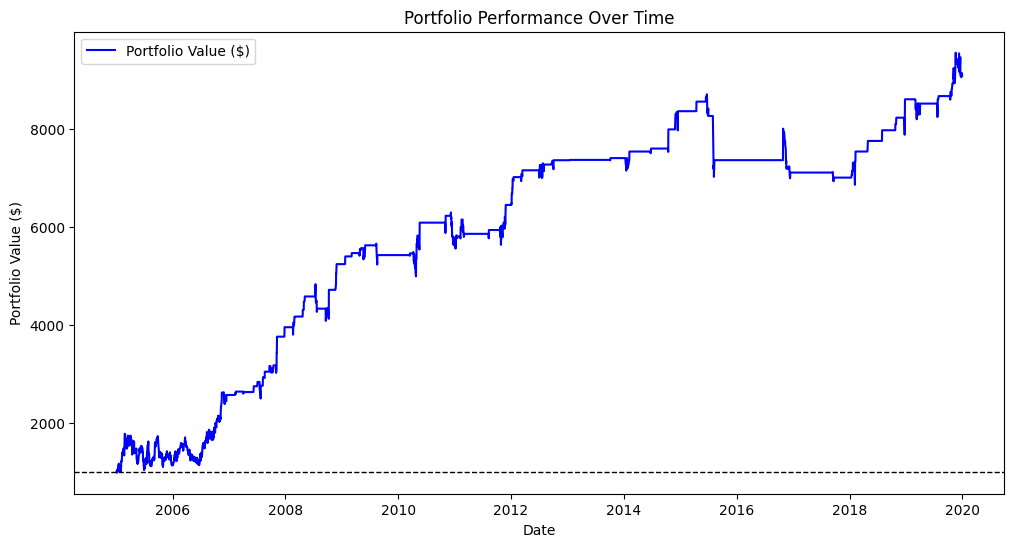

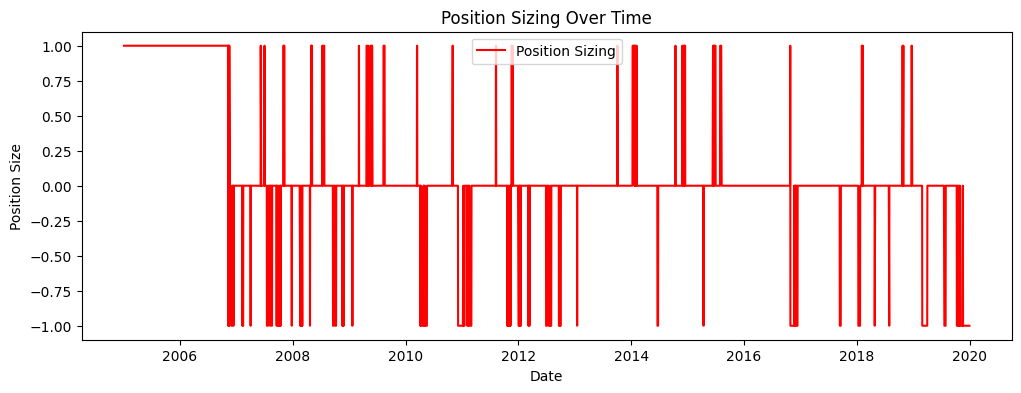

[*********************100%***********************]  1 of 1 completed


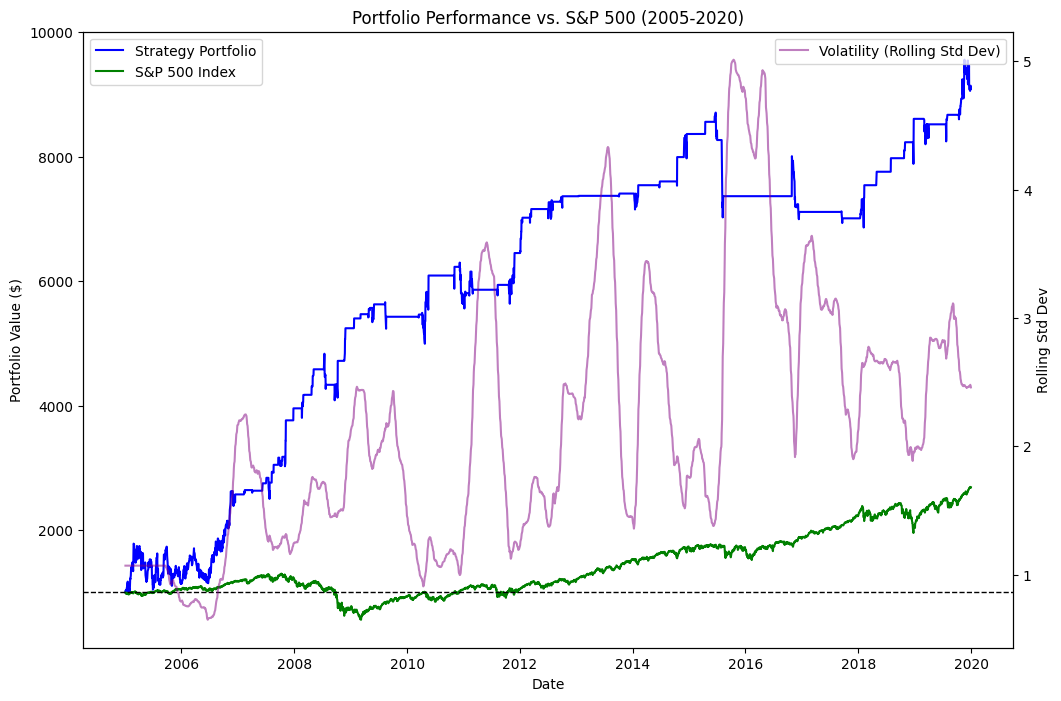

In [10]:
# Initial capital
initial_capital = 1000

data['Spread_Returns'] = data['Spread'].pct_change()

data['Position'] = data['Position'].fillna(0)
data['Spread_Returns'] = data['Spread_Returns'].fillna(0)
data['Position'] = pd.to_numeric(data['Position'], errors='coerce').fillna(0)
data['Strategy_Returns'] = data['Position'].shift(1) * data['Spread_Returns']
data['Cumulative_Strategy_Returns'] = (1 + data['Strategy_Returns']).cumprod()
data['Portfolio_Value'] = initial_capital * data['Cumulative_Strategy_Returns']

# Maximum Drawdown
portfolio_value = data['Portfolio_Value']
rolling_max = portfolio_value.expanding().max()
drawdowns = (portfolio_value - rolling_max) / rolling_max
max_drawdown = drawdowns.min()

# Calculate performance metrics
sharpe_ratio = data['Strategy_Returns'].mean() / data['Strategy_Returns'].std() * (252 ** 0.5)  # Annualized
win_rate = (data['Strategy_Returns'] > 0).sum() / data['Strategy_Returns'].count()

print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Win Rate: {win_rate:.2%}")
print(f"Maximum Drawdown: {max_drawdown:.2%}")
print(f"Final Portfolio Value: ${data['Portfolio_Value'].iloc[-1]:.2f}")

#  cumulative portfolio value
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Portfolio_Value'], label='Portfolio Value ($)', color='blue')
plt.axhline(initial_capital, color='black', linestyle='--', linewidth=1)
plt.legend()
plt.title("Portfolio Performance Over Time")
plt.xlabel("Date")
plt.ylabel("Portfolio Value ($)")
plt.show()

# Adjusted Positions over time
plt.figure(figsize=(12,4))
plt.plot(data.index, data['Position'], label='Position Sizing', color='red')
plt.legend()
plt.title("Position Sizing Over Time")
plt.xlabel("Date")
plt.ylabel("Position Size")
plt.show()


low_vol_threshold = data['rolling_std'].quantile(0.33)
high_vol_threshold = data['rolling_std'].quantile(0.67)

sp500 = yf.download('^GSPC', start='2005-01-01', end='2020-01-01')
sp500['Returns'] = sp500['Close'].pct_change().fillna(0)
sp500['Cumulative_Returns'] = (1 + sp500['Returns']).cumprod()
sp500['Portfolio_Value'] = initial_capital * sp500['Cumulative_Returns']

fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(data.index, data['Portfolio_Value'], label='Strategy Portfolio', color='blue')
ax1.plot(sp500.index, sp500['Portfolio_Value'], label='S&P 500 Index', color='green')
ax1.axhline(initial_capital, color='black', linestyle='--', linewidth=1)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value ($)")
ax1.set_title("Portfolio Performance vs. S&P 500 (2005-2020)")
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(data.index, data['rolling_std'], label='Volatility (Rolling Std Dev)', color='purple', alpha=0.5)
ax2.set_ylabel("Rolling Std Dev")
ax2.legend(loc='upper right')

plt.show()


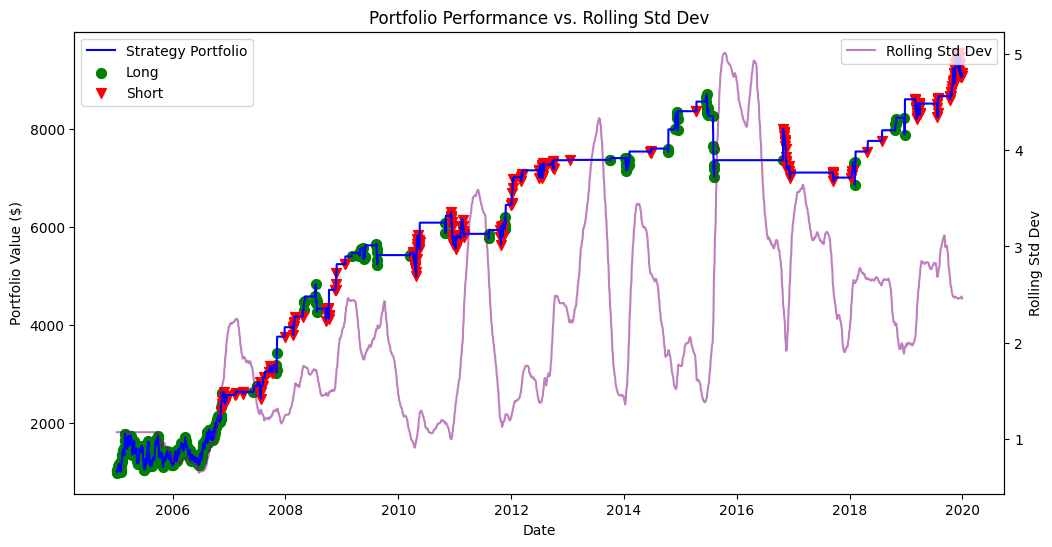

In [11]:
# Plot Portfolio Returns vs Rolling Standard Deviation
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Portfolio Performance
ax1.plot(data.index, data['Portfolio_Value'], label='Strategy Portfolio', color='blue')
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value ($)")
ax1.set_title("Portfolio Performance vs. Rolling Std Dev")
ax1.legend(loc='upper left')

# Create a second y-axis for Volatility
ax2 = ax1.twinx()
ax2.plot(data.index, data['rolling_std'], label='Rolling Std Dev', color='purple', alpha=0.5)
ax2.set_ylabel("Rolling Std Dev")
ax2.legend(loc='upper right')

# Mark trade positions on the Portfolio Performance line
long_positions = data[data['Position'] > 0]
short_positions = data[data['Position'] < 0]

ax1.scatter(long_positions.index, long_positions['Portfolio_Value'], marker='o', color='green', label='Long', s=50)
ax1.scatter(short_positions.index, short_positions['Portfolio_Value'], marker='v', color='red', label='Short', s=50)

ax1.legend()
plt.show()